# A VAE to Generate Doom Screens

In [10]:
import os
import numpy as np
from keras.callbacks import ModelCheckpoint

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10
from keras import layers
import keras

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Get some Data...
!wget http://folk.uio.no/charlepm/datasets/doom_images.npz

--2019-08-28 23:09:41--  http://folk.uio.no/charlepm/datasets/doom_images.npz
Resolving folk.uio.no (folk.uio.no)... 129.240.121.81, 2001:700:100:121::81
Connecting to folk.uio.no (folk.uio.no)|129.240.121.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74242603 (71M)
Saving to: ‘doom_images.npz’

doom_images.npz     100%[===================>]  70,80M  4,42MB/s    in 20s     

2019-08-28 23:10:01 (3,48 MB/s) - ‘doom_images.npz’ saved [74242603/74242603]



(23874, 64, 64, 3)

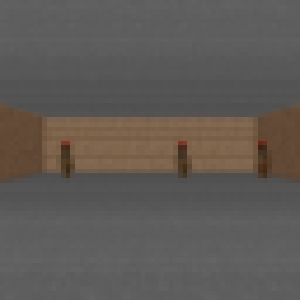

In [3]:
# Test loading new file.
with np.load('doom_images.npz') as data:
    doom_arrays = data['arr_0']
display(doom_arrays.shape)

from IPython.display import Image, display
from keras.preprocessing import image
img = image.array_to_img(doom_arrays[0], scale=False)
display(img.resize((300, 300)))

In [9]:
# The data, split between train and test sets:
x_train = doom_arrays
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
#print(x_test.shape[0], 'test samples')

x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255

x_train shape: (23874, 64, 64, 3)
23874 train samples


In [ ]:
# Network Hyperparameters
img_rows, img_cols, img_chns = 64, 64, 3
latent_dim = 64
intermediate_dim = 128
epsilon_std = 1.0
filters = 32
num_conv = 3

batch_size = 256
epochs = 50

img_size = (img_rows, img_cols, img_chns)
original_dim = img_rows * img_cols * img_chns

In [4]:
# Encoder
input_img = Input(shape=img_size, name='encoder_input')
x = Conv2D(img_chns, kernel_size=(2, 2), padding='same', activation='relu')(input_img)
x = Conv2D(filters, kernel_size=(2, 2), padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(filters, kernel_size=(2, 2), padding='same', activation='relu', strides=(2, 2))(x)
# x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='same')(x) # try a max pooling layer here instead of the previous stride
x = Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1)(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
x = Dense(intermediate_dim, activation='relu', name='latent_project')(x)

print("Shape before flattening:", shape_before_flattening)

# mean and var
z_mean = Dense(latent_dim, name='Z_mean')(x)
z_log_var = Dense(latent_dim, name='Z_var')(x)

# make an encoder model (not used until after training)
encoder = Model(input_img, z_mean)

# sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling, name="Z_sample")([z_mean, z_log_var])

# decoder
decoder_input = layers.Input(K.int_shape(z)[1:])
y = Dense(intermediate_dim, activation='relu')(decoder_input)  # (z)
y = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(y)
y = Reshape(shape_before_flattening[1:])(y)
y = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=1, activation='relu',
                    name='deconv_1')(y)  # deconv 1
y = Conv2DTranspose(filters, kernel_size=num_conv, padding='same', strides=(2, 2), activation='relu',
                    name='deconv_2')(y)  # deconv 2
y = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu',
                    name='deconv_3')(y)  # deconv 3, upsamp
y = Conv2D(img_chns, kernel_size=2, padding='valid', activation='sigmoid', name="mean_squash")(y)  # mean squash
decoder = Model(decoder_input, y, name="Decoder")
z_decoded = decoder(z)  # y

def xent(y_true, y_pred):
    return keras.metrics.binary_crossentropy(y_true, y_pred)

def kl_measure(loc, log_var):
    return -0.5 * K.mean(1 + log_var - K.square(loc) - K.exp(log_var), axis=-1)

def kl_custom_metric(y_true, y_pred):
    # Ignore input and take from z tensors.
    return kl_measure(z_mean, z_log_var)

class VAELayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(VAELayer, self).__init__(**kwargs)

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        r_loss = original_dim * xent(x, z_decoded)
        kl_loss = kl_measure(z_mean, z_log_var)
        print("KL Shape:", K.int_shape(kl_loss))
        print("Xent shape:", K.int_shape(r_loss))
        return K.mean(r_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = VAELayer()([input_img, z_decoded])

vae = Model(input_img, y, name="VAE")
vae.compile(optimizer='adam', metrics=['mse', 'binary_crossentropy'])

vae.summary()

Shape before flattening: (None, 16, 16, 32)


In [18]:
history = vae.fit(x_train, shuffle=True, epochs=50, batch_size=128) # try different params here

vae.save_weights(filepath+"full_vae_weights.h5")
encoder.save_weights(filepath+"encoder_only_weights.h5")
decoder.save_weights(filepath+"decoder_only_weights.h5")

# Generates latent z-values for all pictures in one rollout.
def generate_latent_variables(input):
    z_mean = encoder.predict(input, batch_size=1)
    return z_mean

# Regenerates pictures based on latent values.
def generate_picture_from_latent(latent_variables):
    decoded_images = decoder.predict(latent_variables)
    return decoded_images

Epoch 1/50


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/conv2d_1/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/conv2d_1/convolution_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_1/kernel/read)]]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# Encoder part only:
ex = x_train[np.random.randint(len(x_train))]
plt.figure(figsize=(5, 5))
plt.imshow(ex) # cmap ignored if input is 3D (as it should be here)
plt.show()

enc_z = encoder.predict(np.array([ex]))
print(enc_z[0])

ex_dec = decoder.predict(np.array([enc_z[0]]))
# Plot output
plt.figure(figsize=(5, 5))
plt.imshow(ex_dec[0]) # cmap ignored if input is 3D (as it should be here)
plt.show()

In [ ]:
#Input
ex = x_train[np.random.randint(len(x_train))]
plt.figure(figsize=(5, 5))
plt.imshow(ex) # cmap ignored if input is 3D (as it should be here)
plt.show()

# Predict output
ex_dec = vae.predict(np.array([ex]))

# Plot output
plt.figure(figsize=(5, 5))
plt.imshow(ex_dec[0]) # cmap ignored if input is 3D (as it should be here)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# display images generated from randomly sampled latent vector
n = 10 # num images
img_size = 64
figure = np.zeros((img_size * n, img_size * n, img_chns))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = decoder.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img

        #plt.figure(figsize=(5, 5))
        #plt.imshow(img, cmap='Greys_r')
        #plt.show()

plt.figure(figsize=(20, 20))
plt.imshow(figure) # cmap ignored if input is 3D (as it should be here)
plt.show()


In [ ]:
# Save and download models

def save_model_three_ways(model, name="model"):
  # Save the weights
  model.save("./models/doom_" + name + ('_ld_%d_conv_%d_id_%d_e_%d.h5' % (latent_dim, num_conv, intermediate_dim, epochs)))
  model.save_weights("./models/doom_" + name + '_weights.h5')
  # Save the model architecture
  with open("./models/doom_" + name + '_architecture.json', 'w') as f:
    f.write(model.to_json())

save_model_three_ways(vae, name="vae")
save_model_three_ways(encoder, name="encoder")
save_model_three_ways(encoder, name="decoder")

!tar -czvf doom_models.tar.gz models

from google.colab import files
files.download('doom_models.tar.gz')

In [ ]:
# Encoder part only:
ex = x_train[1]
plt.figure(figsize=(5, 5))
plt.imshow(ex) # cmap ignored if input is 3D (as it should be here)
plt.show()

enc_z = encoder.predict(np.array([ex]))[0]
print(enc_z)
z_1 = enc_z[0]
z_2 = enc_z[1]
z_3 = enc_z[2]
z_4 = enc_z[3]
z_5 = enc_z[4]
z_6 = enc_z[5]
z_7 = enc_z[6]
z_8 = enc_z[7]
z_9 = enc_z[8]
z_10 = enc_z[9]
z_11 = enc_z[10]
z_12 = enc_z[11]
z_13 = enc_z[12]
z_14 = enc_z[13]
z_15 = enc_z[14]
z_16 = enc_z[15]

In [ ]:
#@title Number fields { run: "auto", vertical-output: true, form-width: "50px" }
z_1 = -0.86 #@param {type:"slider", min:-1, max:1, step:0.01}
z_2 = -0.93 #@param {type:"slider", min:-1, max:1, step:0.01}
z_3 = 0.39 #@param {type:"slider", min:-1, max:1, step:0.01}
z_4 = -0.83 #@param {type:"slider", min:-1, max:1, step:0.01}
z_5 = 0.15 #@param {type:"slider", min:-1, max:1, step:0.01}
z_6 = 0.23 #@param {type:"slider", min:-1, max:1, step:0.01}
z_7 = 0.51 #@param {type:"slider", min:-1, max:1, step:0.01}
z_8 = -0.8 #@param {type:"slider", min:-1, max:1, step:0.01}
z_9 = 0.77 #@param {type:"slider", min:-1, max:1, step:0.01}
z_10 = -0.69 #@param {type:"slider", min:-1, max:1, step:0.01}
z_11 = 0 #@param {type:"slider", min:-1, max:1, step:0.01}
z_12 = -0.73 #@param {type:"slider", min:-1, max:1, step:0.01}
z_13 = -0.48 #@param {type:"slider", min:-1, max:1, step:0.01}
z_14 = -0.6 #@param {type:"slider", min:-1, max:1, step:0.01}
z_15 = 0.56 #@param {type:"slider", min:-1, max:1, step:0.01}
z_16 = 0.52 #@param {type:"slider", min:-1, max:1, step:0.01}

new_z= np.array([z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_10,z_11,z_12,z_13,z_14,z_15,z_16])
print(new_z)
dec = decoder.predict(np.array([new_z]))
plt.figure(figsize=(10, 10))
plt.imshow(dec[0]) # cmap ignored if input is 3D (as it should be here)
plt.show()